<a href="https://colab.research.google.com/github/18wh1a1234/CrowdCounting/blob/main/CrowdCounting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import *

In [ ]:
import numpy as np

from matplotlib import cm as CM
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import scipy.io as io
from PIL import Image
import PIL
import h5py
import os
import glob
import cv2
import random
import math
import sys
import itertools 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: ShanghaiTech/part_B/test_data/images/IMG_199.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_2.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_20.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_200.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_201.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_202.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_203.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_204.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_205.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_206.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_207.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_208.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_209.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_21.jpg  
  inflating: ShanghaiTech/part_B/test_data/images/IMG_210

In [ ]:
def getPath(data_type):
    root = '/content/shanghaitech_with_people_density_map/ShanghaiTech/'
    print(root)
    if data_type.find('part_A')!=-1:
        target_train = os.path.join(root,r'part_A/train_data','images')
        target_test = os.path.join(root,r'part_A/test_data','images')

    elif data_type.find('part_B')!=-1:
        target_train = os.path.join(root,r'part_B/train_data','images')
        target_test = os.path.join(root,r'part_B/test_data','images')

    train_path = []
    for img_path in glob.glob(os.path.join(target_train, '*.jpg')):
        train_path.append(str(img_path))
        
    test_path = []
    for img_path in glob.glob(os.path.join(target_test, '*.jpg')):
        test_path.append(str(img_path))
        
    return train_path, test_path

def load_density(file_path):
    gt_file = h5py.File(file_path, 'r')
    groundtruth = np.asarray(gt_file['density'])
    groundtruth = np.expand_dims(groundtruth, axis=-1)
    return groundtruth

train_paths, test_paths = getPath('part_B')
gth_train = [path.replace('jpg', 'h5').replace('images', 'ground-truth-h5') for path in train_paths]
gth_test = [path.replace('jpg', 'h5').replace('images', 'ground-truth-h5') for path in test_paths]

print('train len:', len(train_paths))
print('test len:', len(test_paths))


train_labels=np.array([load_density(path) for path in gth_train]).astype('float16')
print(train_labels.shape)
test_labels=np.array([load_density(path) for path in gth_test]).astype('float16')
print(test_labels.shape)

/content/shanghaitech_with_people_density_map/ShanghaiTech/
train len: 400
test len: 316
(400, 768, 1024, 1)
(316, 768, 1024, 1)


## **Data Generation**

In [ ]:
target_type=tf.dtypes.float16
def load_img(path):
    image_string=tf.io.read_file(path)
    image=tf.image.decode_jpeg(image_string,channels=3)
    image=tf.image.convert_image_dtype(image, target_type)
    return image

def gen_translate_func(translate_range):
    def translate_function(img, gth):
        ratio=tf.random.uniform((2,), minval=translate_range[1], maxval=translate_range[0], dtype=tf.dtypes.int32)
        ratio=tf.cast(ratio, target_type)

        out_gth=tfa.image.translate(gth, ratio, 'BILINEAR') 
        out_img=tfa.image.translate(img, ratio, 'BILINEAR') 

        return out_img, out_gth
    return translate_function


In [ ]:
def gen_downsampling_func(downsampling, method='nearest', batch=True):  
    batchadd=1
    if batch==False:
        batchadd=0
    @tf.function
    def _downsampling_function_(img, gth):
        down_ratio=downsampling
        before_resize=tf.reduce_sum(gth)
        gth_shape=tf.shape(gth)
        out_gth=tf.image.resize(gth, (gth_shape[0+batchadd]//down_ratio, gth_shape[1+batchadd]//down_ratio), method=method,antialias=False)
        out_gth=tf.cast(out_gth, dtype=target_type)
        after_resize=tf.reduce_sum(out_gth)
        if (before_resize >= 0.3) and (after_resize > 0.01):
            out_gth=out_gth * before_resize / after_resize
        return img, out_gth
    return _downsampling_function_


In [ ]:
def gen_randomcrop_func(crop_size, batch=True): #image cropping
    batchadd=1
    if batch==False:
        batchadd=0
    @tf.function
    def _random_crop_(img, gth):
        
        output_shape=tf.constant(crop_size)
        img_shape=tf.shape(img)

        ratio_x=tf.random.uniform((1,), minval=0, maxval=img_shape[1+batchadd]-output_shape[1], dtype=tf.dtypes.int32)[0]
        ratio_y=tf.random.uniform((1,), minval=0, maxval=img_shape[0+batchadd]-output_shape[0], dtype=tf.dtypes.int32)[0]

        out_img=tf.image.crop_to_bounding_box(img, ratio_y, ratio_x, output_shape[0], output_shape[1])
        out_gth=tf.image.crop_to_bounding_box(gth, ratio_y, ratio_x, output_shape[0], output_shape[1])

        return out_img, out_gth
    return _random_crop_


In [ ]:
def gen_coarsedrop_func(hole_count, hole_size, hole_prob=0.75): #since o/p is density map so mask imaging
    def _dropout_(image, gth): 
        shape = tf.shape(image)
        BATCH = shape[0]
        IMG_WIDTH = shape[2]
        IMG_HEIGHT = shape[1]
        IMG_WIDTH_F = tf.cast(IMG_WIDTH, tf.float32)
        IMG_HEIGHT_F = tf.cast(IMG_HEIGHT, tf.float32)
        PROBABILITY = hole_prob
        CT = hole_count
        CROP_SIZE = tf.cast(hole_size,tf.int32)
        
        P = tf.cast( tf.random.uniform([], 0.0, 1.0) < PROBABILITY, tf.int32)
        if (P==0): return image, gth
        
        mask = tf.ones((IMG_HEIGHT,IMG_WIDTH,1))
        for k in range(CT):
            
            x = tf.cast( tf.random.uniform([],0.0,IMG_WIDTH_F),tf.int32)
            y = tf.cast( tf.random.uniform([],0.0,IMG_HEIGHT_F),tf.int32)
            
            ya = tf.math.maximum(0,y-CROP_SIZE//2)
            yb = tf.math.minimum(IMG_HEIGHT,y+CROP_SIZE//2)
            xa = tf.math.maximum(0,x-CROP_SIZE//2)
            xb = tf.math.minimum(IMG_WIDTH,x+CROP_SIZE//2)
            
            one = mask[ya:yb,0:xa,:]
            two = tf.zeros([yb-ya,xb-xa,1]) 
            three = mask[ya:yb,xb:IMG_WIDTH,:]
            middle = tf.concat([one,two,three],axis=1)
            mask = tf.concat([mask[0:ya,:,:],middle,mask[yb:IMG_HEIGHT,:,:]],axis=0)
        
        
        mask = tf.cast(mask, dtype='float16')
        return image*mask, gth*mask
    return _dropout_


In [ ]:
def basic_dataset(img_data, label_data, batch_size=1, flip=False, downsampling=1, buffer_size=32, shuffle=False): 
    input_data=tf.data.Dataset.from_tensor_slices(img_data) 
    input_data = input_data.map(load_img) 
    output_data=tf.data.Dataset.from_tensor_slices(label_data)

    if flip:
        input_data=input_data.concatenate(input_data.map(tf.image.flip_left_right))
        output_data=output_data.concatenate(output_data.map(tf.image.flip_left_right))

    dataset=tf.data.Dataset.zip((input_data, output_data))
    if shuffle:
        dataset = dataset.batch(batch_size).repeat().shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    else:
        dataset = dataset.batch(batch_size).repeat()

    if downsampling!=1:
        dataset=dataset.map(gen_downsampling_func(downsampling=downsampling))
    return dataset



In [ ]:
def crop_dataset(img_data, label_data, crop_size, flip, downsampling, batch_size=1, sample_method='bicubic', buffer_size=16, 
hole_count=0, hole_size=100, hole_prob=0.75):
    dataset = basic_dataset(img_data, label_data, flip=flip, batch_size=batch_size, downsampling=1, shuffle=True, buffer_size=buffer_size)
    dataset=dataset.map(gen_randomcrop_func(crop_size))
    if hole_count!=0:
        dataset=dataset.map(gen_coarsedrop_func(hole_count=hole_count, hole_size=hole_size, hole_prob=hole_prob))
    if downsampling!=1: #reducing actual sampling
        dataset=dataset.map(gen_downsampling_func(downsampling=downsampling, method=sample_method))
    return dataset

In [ ]:
def show_images(images, cols = 2, titles = None, padding=1, axis="off", channel1=CM.jet):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = [None for i in range(1,n_images + 1)]
    fig = plt.figure()
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)

        plt.axis(axis)
        plt.subplots_adjust(wspace=padding, hspace=padding)

        if (image.shape[2] == 1):
            image = image[:,:,0]
            plt.imshow(image, cmap=channel1)
        elif np.any(image > 1.0):
            plt.imshow(image / 255.0)
        else:
            plt.imshow(image)
        a.set_title(title, fontsize=20)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

## **Network**

In [ ]:
def CNN(batch_norm=False, middle_activation='relu', final_activation='sigmoid', dtype=tf.dtypes.float16):
    init=RandomNormal(stddev=0.01)
    
    activationDict = {
        'sigmoid': tf.math.sigmoid,
        'relu': tf.nn.relu,
    }
    vgg16 = VGG16(weights='imagenet', include_top=False)
    vgg16.trainable=False
    
    input_layer = Input(shape=(None, None, 3))
    x = input_layer
    if (normal_input):
        x = Lambda(lambda batch: (batch - tf.constant([0.485,0.456,0.406], dtype=dtype)) / tf.constant([0.229,0.224,0.225],dtype=dtype))(x)

    count = 0
    for layer in vgg16.layers:
        layer.trainable = False
        x = layer(x)
        if 'conv' in layer.name:
            count+=1
        if count == 10:
            break;
            
    
    if batch_norm:
        x = BatchNormalization()(x)
    
    if batch_norm:
        x = Conv2D(512, (3, 3), dilation_rate=2, use_bias=False)(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(512, (3, 3), dilation_rate=2, use_bias=True)(x)
    x = Activation(activationDict[middle_activation])(x)
    
    
    if batch_norm:
        x = Conv2D(256, (3, 3), dilation_rate=2, use_bias=False)(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(256, (3, 3), dilation_rate=2, use_bias=True)(x)
    x = Activation(activationDict[middle_activation])(x)
    
    
    if batch_norm:
        x = Conv2D(128, (3, 3), dilation_rate=2, use_bias=False)(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(128, (3, 3), dilation_rate=2, use_bias=True)(x)
    x = Activation(activationDict[middle_activation])(x)
    
    
    if batch_norm:
        x = Conv2D(128, (3, 3), dilation_rate=2, use_bias=False)(x)
        x = BatchNormalization()(x)
    else:
        x = Conv2D(128, (3, 3), dilation_rate=2, use_bias=True)(x)
    x = Activation(activationDict[middle_activation])(x)
        
    x = Conv2D(1, (1, 1), dilation_rate=1, use_bias=False)(x)
    x = Activation(activationDict[final_activation])(x)
    
    model = Model(input_layer, x)
    return model

# **Augumentation  **

In [ ]:
batch_size=8
train_size=320

val_gen = basic_dataset(train_paths[train_size:], train_labels[train_size:], batch_size=1, flip=False, downsampling=8, buffer_size=16, shuffle=False)
test_gen = basic_dataset(test_paths, test_labels, batch_size=1, flip=False, downsampling=8, buffer_size=16, shuffle=False)
train_gen  = crop_dataset(train_paths[:train_size], train_labels[:train_size], crop_size=(760,1000), flip=True, downsampling=8, batch_size=batch_size, sample_method='bicubic', buffer_size=8)

model = CNN(middle_activation='relu', final_activation='sigmoid', dtype=tf.dtypes.float32)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, None, None, 3))

print('train baseline: ', np.mean( np.sum(train_labels[:train_size], axis=(1,2,3))))
print('val baseline: ', np.mean( np.sum(train_labels[320:], axis=(1,2,3))))

history = model.fit(train_gen, steps_per_epoch=int(train_size*2/batch_size), epochs=80, verbose=1,
              workers=6, validation_data=val_gen, validation_steps=80)

model.load_weights(filepath)
model.evaluate(val_gen, steps=80, verbose=1, workers=4)
model.evaluate(test_gen, steps=316, verbose=1, workers=4)

58892288/58889256 [==============================] - 0s 0us/step
  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)

train baseline:  119.94
val baseline:  115.2
316/316 [==============================] - 27s 86ms/step - loss: 0.0421 - density_mae: 35.0295


[0.042132776230573654, 35.02949905395508]

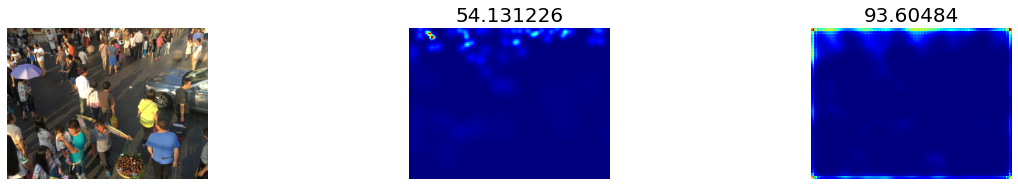

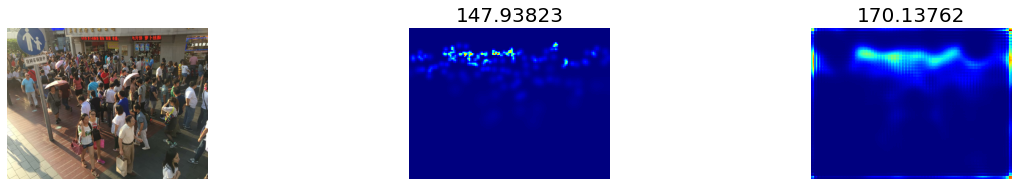

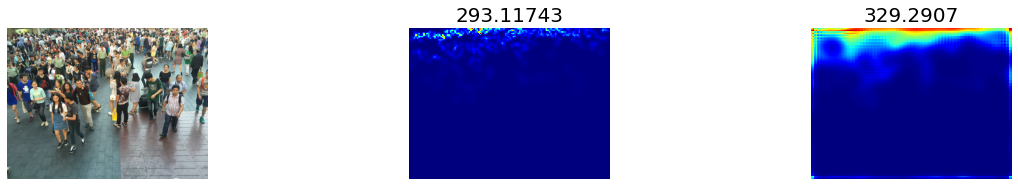

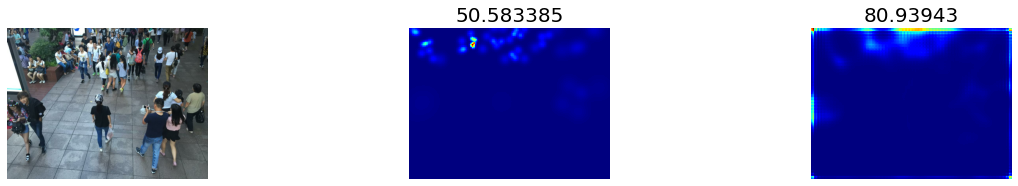

In [ ]:
for a,b in test_gen.take(4):
    c = model.predict(a)
    a = tf.cast(a, dtype=tf.dtypes.float32)
    b = tf.cast(b, dtype=tf.dtypes.float32)
    c = c.astype('float32')
    show_images([a[0], b[0], c[0]], 1, ['', np.sum(b[0]), np.sum(c[0])])